In [16]:
# Core imports
from pathlib import Path
from datetime import datetime

import asdf
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from IPython.display import display, HTML

# Configure matplotlib for dark theme
plt.style.use('dark_background')

# Default paths
CAPTURES_DIR = Path("../data/captures")
FITS_OUTPUT_DIR = Path("../data/fits_export")

## 1. List Available Session Archives

In [17]:
def list_session_archives(captures_dir: Path = CAPTURES_DIR) -> list[Path]:
    """List all session ASDF archives."""
    archives = sorted(captures_dir.glob("session_*.asdf"), reverse=True)
    
    print(f"Found {len(archives)} session archive(s):\n")
    for i, path in enumerate(archives):
        size_mb = path.stat().st_size / (1024 * 1024)
        print(f"  [{i}] {path.name} ({size_mb:.1f} MB)")
    
    return archives

archives = list_session_archives()

Found 1 session archive(s):

  [0] session_20251231.asdf (37.1 MB)


## 2. Load and Explore Session

In [18]:
# Select archive by index
ARCHIVE_INDEX = 0  # Change this to select different archive

if archives:
    archive_path = archives[ARCHIVE_INDEX]
    print(f"Loading: {archive_path}")
else:
    print("No archives found. Capture some frames first!")
    archive_path = None

Loading: ../data/captures/session_20251231.asdf


In [19]:
def show_session_info(path: Path) -> dict:
    """Display session metadata and frame counts for all cameras."""
    with asdf.open(str(path)) as af:
        tree = af.tree
        meta = tree.get("metadata", {})
        cameras = tree.get("cameras", {})
        
        print("=" * 60)
        print(f"Session: {path.name}")
        print("=" * 60)
        
        print(f"\n📅 Session Date: {meta.get('session_date', 'Unknown')}")
        print(f"📁 Created: {meta.get('created', 'Unknown')}")
        print(f"📋 Format Version: {meta.get('format_version', '1.0')}")
        
        result = {"metadata": meta, "cameras": {}}
        
        for cam_name, cam_data in cameras.items():
            info = cam_data.get("info", {})
            icon = "🔭" if cam_name == "finder" else "📷"
            
            print(f"\n{icon} {cam_name.upper()} Camera:")
            print(f"  Name: {info.get('name', 'Unknown')}")
            print(f"  Sensor: {info.get('sensor_width', '?')} x {info.get('sensor_height', '?')}")
            print(f"  Color: {info.get('is_color', False)} (Bayer: {info.get('bayer_pattern', 'N/A')})")
            
            print(f"  Frames:")
            frame_counts = {}
            for frame_type in ["light", "dark", "flat", "bias"]:
                frames = cam_data.get(frame_type, [])
                count = len(frames)
                frame_counts[frame_type] = count
                if count > 0:
                    icon_f = {"light": "🌟", "dark": "⬛", "flat": "📄", "bias": "⚡"}[frame_type]
                    print(f"    {icon_f} {frame_type}: {count}")
            
            result["cameras"][cam_name] = {"info": info, "frame_counts": frame_counts}
        
        return result

if archive_path:
    session_info = show_session_info(archive_path)

Session: session_20251231.asdf

📅 Session Date: 20251231
📁 Created: 2026-01-01T05:02:59.597222+00:00
📋 Format Version: 1.0

🔭 FINDER Camera:
  Name: ZWO ASI120MC-S(Camera)
  Sensor: 1280 x 960
  Color: True (Bayer: RGGB)
  Frames:
    🌟 light: 4

📷 MAIN Camera:
  Name: ZWO ASI482MC
  Sensor: 1920 x 1080
  Color: True (Bayer: RGGB)
  Frames:
    🌟 light: 3
    ⬛ dark: 1
    📄 flat: 2
    ⚡ bias: 1


## 3. Preview Frames (Thumbnails)

In [20]:
def auto_stretch(img: np.ndarray, percentile: tuple = (1, 99)) -> np.ndarray:
    """Auto-stretch image for display (percentile-based)."""
    low, high = np.percentile(img, percentile)
    if high <= low:
        return np.zeros_like(img, dtype=np.float32)
    stretched = (img.astype(np.float32) - low) / (high - low)
    return np.clip(stretched, 0, 1)

def preview_frames(
    path: Path, 
    camera: str = "main", 
    frame_type: str = "light", 
    max_frames: int = 12
):
    """Show thumbnail grid of frames with metadata."""
    with asdf.open(str(path)) as af:
        cameras = af.tree.get("cameras", {})
        if camera not in cameras:
            print(f"Camera '{camera}' not found. Available: {list(cameras.keys())}")
            return
        
        frames = cameras[camera].get(frame_type, [])
        
        if not frames:
            print(f"No {frame_type} frames found for {camera} camera.")
            return
        
        n = min(len(frames), max_frames)
        cols = min(4, n)
        rows = (n + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        if n == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        for i in range(n):
            frame = frames[i]
            img = np.array(frame["data"])
            meta = frame.get("meta", {})
            
            # Auto-stretch for visibility
            stretched = auto_stretch(img)
            
            axes[i].imshow(stretched, cmap='gray', origin='lower')
            axes[i].set_title(
                f"#{i} | {meta.get('exposure_us', 0)/1e6:.2f}s | G{meta.get('gain', '?')}",
                fontsize=9
            )
            axes[i].axis('off')
        
        # Hide unused axes
        for i in range(n, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f"{camera.upper()} - {frame_type} frames ({len(frames)} total)", fontsize=14)
        plt.tight_layout()
        plt.show()

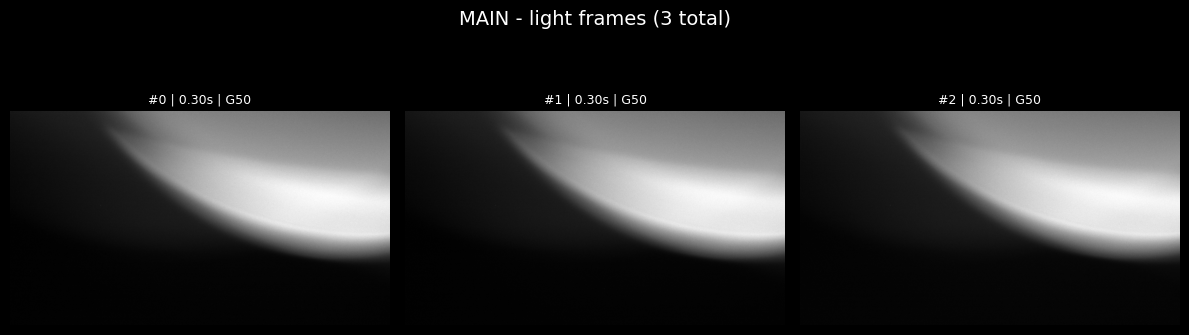

In [21]:
# Preview main camera light frames
if archive_path:
    preview_frames(archive_path, camera="main", frame_type="light")

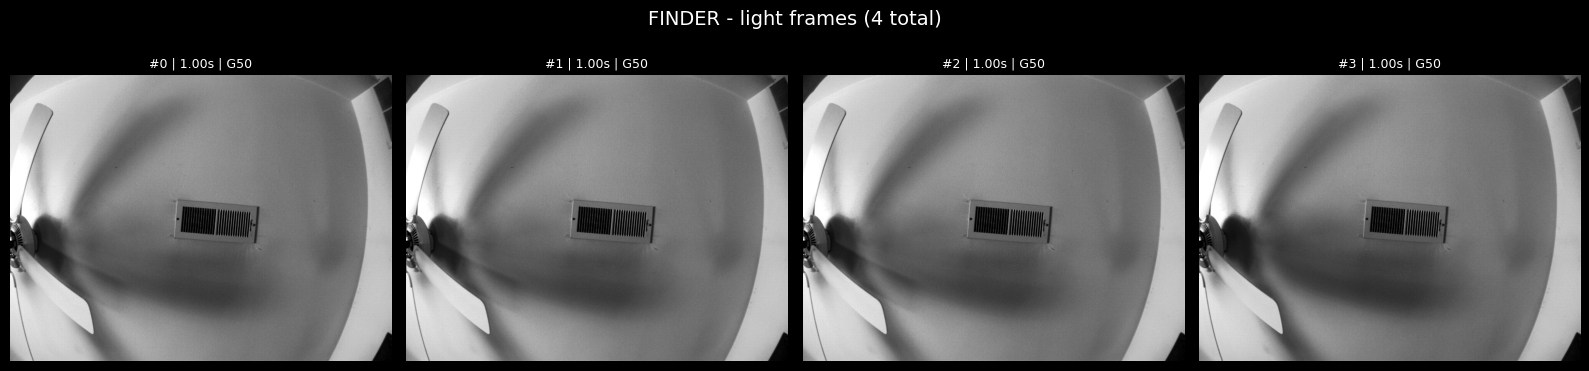

In [22]:
# Preview finder camera light frames
if archive_path:
    preview_frames(archive_path, camera="finder", frame_type="light")

## 4. Frame Statistics & Quality Analysis

In [23]:
def analyze_frames(path: Path, camera: str = "main", frame_type: str = "light"):
    """Compute statistics for all frames of a type."""
    with asdf.open(str(path)) as af:
        cameras = af.tree.get("cameras", {})
        if camera not in cameras:
            print(f"Camera '{camera}' not found.")
            return None
        
        frames = cameras[camera].get(frame_type, [])
        
        if not frames:
            print(f"No {frame_type} frames found for {camera}.")
            return None
        
        stats = []
        for i, frame in enumerate(frames):
            img = np.array(frame["data"])
            meta = frame.get("meta", {})
            
            stats.append({
                "index": i,
                "min": img.min(),
                "max": img.max(),
                "mean": img.mean(),
                "std": img.std(),
                "exposure_s": meta.get("exposure_us", 0) / 1e6,
                "gain": meta.get("gain", 0),
                "temp": meta.get("camera_temp", 0),
                "timestamp": meta.get("timestamp", ""),
            })
        
        # Print table
        print(f"\n{camera.upper()} - {frame_type} Statistics:")
        print("-" * 90)
        print(f"{'#':>3} | {'Min':>6} | {'Max':>6} | {'Mean':>8} | {'Std':>8} | {'Exp(s)':>6} | {'Gain':>4} | {'Temp':>5} | Time")
        print("-" * 90)
        
        for s in stats:
            ts_short = s['timestamp'].split('T')[1][:8] if 'T' in s['timestamp'] else s['timestamp'][:8]
            print(f"{s['index']:>3} | {s['min']:>6} | {s['max']:>6} | {s['mean']:>8.1f} | {s['std']:>8.1f} | {s['exposure_s']:>6.2f} | {s['gain']:>4} | {s['temp']:>5.1f} | {ts_short}")
        
        # Flag outliers
        if len(stats) > 2:
            means = [s['mean'] for s in stats]
            group_mean = np.mean(means)
            group_std = np.std(means)
            
            outliers = [s['index'] for s in stats if abs(s['mean'] - group_mean) > 2 * group_std]
            if outliers:
                print(f"\n⚠️  Potential outliers (mean > 2σ from group): {outliers}")
        
        return stats

if archive_path:
    stats = analyze_frames(archive_path, camera="main", frame_type="light")


MAIN - light Statistics:
------------------------------------------------------------------------------------------
  # |    Min |    Max |     Mean |      Std | Exp(s) | Gain |  Temp | Time
------------------------------------------------------------------------------------------
  0 |    448 |   6976 |   1790.5 |   1419.7 |   0.30 |   50 |   0.0 | 05:03:07
  1 |    395 |   7104 |   1811.9 |   1449.2 |   0.30 |   50 |   0.0 | 05:03:09
  2 |    395 |   7360 |   1787.8 |   1418.6 |   0.30 |   50 |   0.0 | 05:16:03


## 5. Extract Frames to FITS

Export individual frames or batches for use in stacking software (Siril, PixInsight, DeepSkyStacker).

In [24]:
def extract_to_fits(
    asdf_path: Path,
    camera: str = "main",
    frame_type: str = "light",
    indices: list[int] | None = None,
    output_dir: Path = FITS_OUTPUT_DIR,
) -> list[Path]:
    """Extract frames from session ASDF to individual FITS files.
    
    Args:
        asdf_path: Path to session ASDF archive
        camera: Camera to extract from ("finder" or "main")
        frame_type: Type of frames to extract (light, dark, flat, bias)
        indices: List of frame indices to extract, or None for all
        output_dir: Directory for FITS output
        
    Returns:
        List of paths to created FITS files
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    created_files = []
    
    with asdf.open(str(asdf_path)) as af:
        session_meta = af.tree.get("metadata", {})
        cameras = af.tree.get("cameras", {})
        
        if camera not in cameras:
            print(f"Camera '{camera}' not found. Available: {list(cameras.keys())}")
            return []
        
        cam_data = cameras[camera]
        cam_info = cam_data.get("info", {})
        frames = cam_data.get(frame_type, [])
        
        if not frames:
            print(f"No {frame_type} frames found for {camera}.")
            return []
        
        # Determine which frames to extract
        if indices is None:
            indices = list(range(len(frames)))
        
        # Base name from session date
        session_date = session_meta.get("session_date", asdf_path.stem)
        
        print(f"Extracting {len(indices)} {camera}/{frame_type} frames to FITS...\n")
        
        for i in indices:
            if i >= len(frames):
                print(f"  ⚠️  Index {i} out of range, skipping")
                continue
            
            frame = frames[i]
            img = np.array(frame["data"])
            frame_meta = frame.get("meta", {})
            
            # Create FITS HDU with header
            hdu = fits.PrimaryHDU(img)
            
            # Standard FITS headers
            hdu.header['EXPTIME'] = frame_meta.get('exposure_us', 0) / 1e6
            hdu.header['GAIN'] = frame_meta.get('gain', 0)
            hdu.header['CAMERA'] = cam_info.get('name', 'Unknown')
            hdu.header['DATE-OBS'] = frame_meta.get('timestamp', '')
            hdu.header['IMAGETYP'] = frame_type.upper()
            hdu.header['BITPIX'] = 16
            hdu.header['NAXIS1'] = cam_info.get('sensor_width', img.shape[1])
            hdu.header['NAXIS2'] = cam_info.get('sensor_height', img.shape[0])
            
            # Bayer pattern for color cameras
            if cam_info.get('bayer_pattern'):
                hdu.header['BAYERPAT'] = cam_info.get('bayer_pattern')
            
            # Camera temperature
            if 'camera_temp' in frame_meta:
                hdu.header['CCD-TEMP'] = frame_meta['camera_temp']
            
            # Generate filename: session_camera_type_0001.fits
            filename = f"{session_date}_{camera}_{frame_type}_{i:04d}.fits"
            filepath = output_dir / filename
            
            hdu.writeto(str(filepath), overwrite=True)
            created_files.append(filepath)
            print(f"  ✓ {filename}")
        
        print(f"\n✅ Exported {len(created_files)} files to {output_dir}")
        return created_files

In [25]:
# Extract all main camera light frames
if archive_path:
    fits_files = extract_to_fits(archive_path, camera="main", frame_type="light")

Extracting 3 main/light frames to FITS...

  ✓ 20251231_main_light_0000.fits
  ✓ 20251231_main_light_0001.fits
  ✓ 20251231_main_light_0002.fits

✅ Exported 3 files to ../data/fits_export


In [26]:
# Extract finder frames
if archive_path:
    finder_fits = extract_to_fits(archive_path, camera="finder", frame_type="light")

Extracting 4 finder/light frames to FITS...

  ✓ 20251231_finder_light_0000.fits
  ✓ 20251231_finder_light_0001.fits
  ✓ 20251231_finder_light_0002.fits
  ✓ 20251231_finder_light_0003.fits

✅ Exported 4 files to ../data/fits_export


In [27]:
# Extract specific frames by index (e.g., skip outliers)
# fits_files = extract_to_fits(archive_path, camera="main", frame_type="light", indices=[0, 1, 3, 5])

In [28]:
# Extract calibration frames
# extract_to_fits(archive_path, camera="main", frame_type="dark")
# extract_to_fits(archive_path, camera="main", frame_type="flat")
# extract_to_fits(archive_path, camera="main", frame_type="bias")

## 6. View Single Frame in Detail

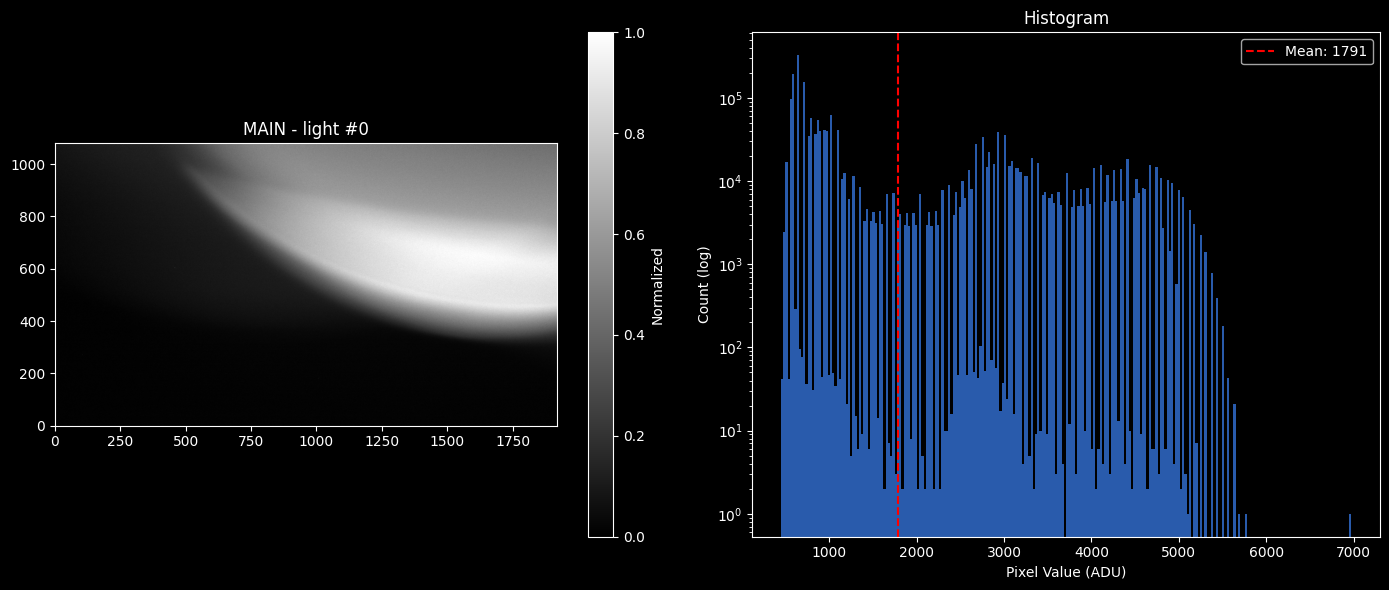


📋 Frame Metadata:
  bayer_pattern: RGGB
  camera_id: 1
  camera_name: ZWO ASI482MC
  camera_temp: 0.0
  capture_mode: raw16_stream
  coordinates: {'altitude': 89.18158628736813, 'azimuth': 331.2023445848726, 'coordinate_source': 'sensor', 'coordinate_timestamp': '2026-01-01T05:03:07.182012+00:00', 'dec': 30.951127849449524, 'dec_dms': '+30° 57\' 04.1"', 'humidity': 40.12, 'ra': 78.02098680352334, 'ra_hms': '05h 12m 05.0s', 'ra_hours': 5.20139912023489, 'temperature': 27.03}
  exposure_us: 300000
  gain: 50
  height: 1080
  is_color: True
  timestamp: 2026-01-01T05:03:07.182012+00:00
  width: 1920

📊 Statistics:
  Min: 448, Max: 6976
  Mean: 1790.5, Std: 1419.7


In [29]:
def view_frame(path: Path, camera: str = "main", frame_type: str = "light", index: int = 0):
    """View a single frame with histogram and metadata."""
    with asdf.open(str(path)) as af:
        cameras = af.tree.get("cameras", {})
        if camera not in cameras:
            print(f"Camera '{camera}' not found.")
            return
        
        frames = cameras[camera].get(frame_type, [])
        
        if index >= len(frames):
            print(f"Index {index} out of range (max: {len(frames)-1})")
            return
        
        frame = frames[index]
        img = np.array(frame["data"])
        meta = frame.get("meta", {})
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Image with auto-stretch
        stretched = auto_stretch(img)
        im = axes[0].imshow(stretched, cmap='gray', origin='lower')
        axes[0].set_title(f"{camera.upper()} - {frame_type} #{index}")
        plt.colorbar(im, ax=axes[0], label='Normalized')
        
        # Histogram
        axes[1].hist(img.flatten(), bins=256, color='#3b82f6', alpha=0.7, log=True)
        axes[1].set_xlabel('Pixel Value (ADU)')
        axes[1].set_ylabel('Count (log)')
        axes[1].set_title('Histogram')
        axes[1].axvline(img.mean(), color='red', linestyle='--', label=f'Mean: {img.mean():.0f}')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print metadata
        print("\n📋 Frame Metadata:")
        for k, v in meta.items():
            print(f"  {k}: {v}")
        
        print(f"\n📊 Statistics:")
        print(f"  Min: {img.min()}, Max: {img.max()}")
        print(f"  Mean: {img.mean():.1f}, Std: {img.std():.1f}")

if archive_path:
    view_frame(archive_path, camera="main", frame_type="light", index=0)

## 7. Debayer Preview (Color Cameras)

Preview what the color image looks like after debayering.

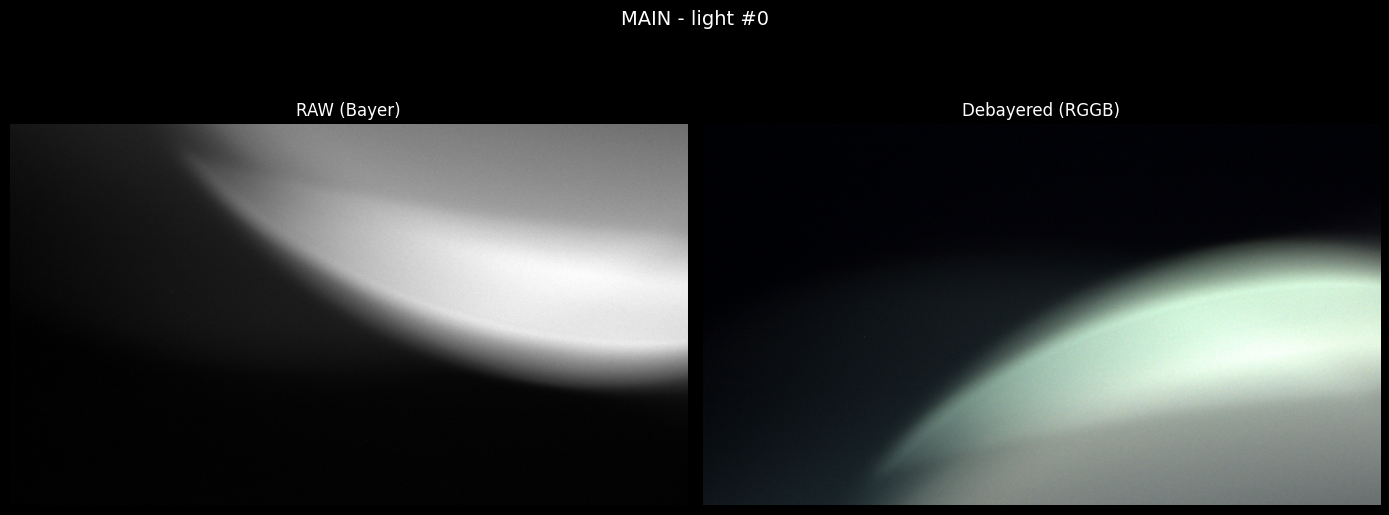

In [30]:
def debayer_preview(path: Path, camera: str = "main", frame_type: str = "light", index: int = 0):
    """Preview debayered color image (for color cameras)."""
    try:
        import cv2
    except ImportError:
        print("OpenCV required for debayering. Install with: pip install opencv-python")
        return
    
    with asdf.open(str(path)) as af:
        cameras = af.tree.get("cameras", {})
        if camera not in cameras:
            print(f"Camera '{camera}' not found.")
            return
        
        cam_info = cameras[camera].get("info", {})
        
        if not cam_info.get("is_color", False):
            print(f"{camera} is a monochrome camera - no debayering needed.")
            return
        
        frames = cameras[camera].get(frame_type, [])
        if index >= len(frames):
            print(f"Index {index} out of range")
            return
        
        img = np.array(frames[index]["data"])
        bayer = cam_info.get("bayer_pattern", "RGGB")
        
        # Map bayer pattern to OpenCV code
        bayer_map = {
            "RGGB": cv2.COLOR_BAYER_RG2RGB,
            "BGGR": cv2.COLOR_BAYER_BG2RGB,
            "GRBG": cv2.COLOR_BAYER_GR2RGB,
            "GBRG": cv2.COLOR_BAYER_GB2RGB,
        }
        
        if bayer not in bayer_map:
            print(f"Unknown bayer pattern: {bayer}")
            return
        
        # Convert to 8-bit for debayering (OpenCV limitation)
        img_8bit = (auto_stretch(img) * 255).astype(np.uint8)
        
        # Debayer
        color = cv2.cvtColor(img_8bit, bayer_map[bayer])
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        axes[0].imshow(auto_stretch(img), cmap='gray', origin='lower')
        axes[0].set_title('RAW (Bayer)')
        axes[0].axis('off')
        
        axes[1].imshow(color[::-1], origin='lower')  # Flip for correct orientation
        axes[1].set_title(f'Debayered ({bayer})')
        axes[1].axis('off')
        
        plt.suptitle(f"{camera.upper()} - {frame_type} #{index}", fontsize=14)
        plt.tight_layout()
        plt.show()

if archive_path:
    debayer_preview(archive_path, camera="main", frame_type="light", index=0)